In [4]:
import matplotlib.pyplot as plt

import re

import pandas as pd

import numpy as np

pd.options.display.max_columns = 30

from numpy import *

import plotly.express as px

import plotly.graph_objects as go

import seaborn as sns

from wordcloud import WordCloud, STOPWORDS

from sklearn import *


                                  Open Documents and save contents as string variables

In [5]:
EssayFileName = "Vaccines are Beneficial.txt"

ResumeFileName = "Resume.txt"

LabFileName = "EEE 334 Lab 1.txt"


EssayLines = ""

Resumelines = ""

LabLines = ""


def Read(FileName, lines):
    with open(FileName, "r", encoding = 'utf-8') as File:
        lines = File.read()
    return(lines)
    
EssayText = Read(EssayFileName, EssayLines)

ResumeText = Read(ResumeFileName, Resumelines)

LabText = Read(LabFileName, LabLines)

    

                                                Clean  and Sort Data

In [6]:
def CleanData(Text):
    Text = re.sub(r'[^a-zA-Z]', '', Text)
    
    Text = Text.lower()
    
    return(Text)

EssayText = CleanData(EssayText)

ResumeText = CleanData(ResumeText)

LabText = CleanData(LabText) 

I removed all non-alphabetic characters and changed all uppercase letters to lowercase.  That ensures I can obtain the frequency of just the letters and that all instances of the same letter will counted without regard to case.

                                        Get Letter Frequencies as Dictionaries 

In [7]:
def GetFrequencies(Text):  
    LetterFrequencies = {}
    for keys in Text:
        LetterFrequencies[keys] = LetterFrequencies.get(keys, 0) + 1
    return(LetterFrequencies)

EssayFrequencyDict = GetFrequencies(EssayText)

ResumeFrequencyDict = GetFrequencies(ResumeText)

LabFrequencyDict = GetFrequencies(LabText)

                                Convert Dictionaries to Data Frames and Sort Frequency by Letter

In [8]:
def ConvertAndSort(FrequencyDict, column2):
    Frequency_df = pd.DataFrame(FrequencyDict.items(), columns=['Letter', column2]) 

    Frequency_df = Frequency_df.sort_values("Letter")

    Frequency_df = Frequency_df[Frequency_df.Letter != " "].reset_index()  #renumber rows from 0 to 1 from the top down
    
    Frequency_df.pop('index')  #remove column containing prior order as I have no need of it
    
    Frequency_df.dropna(inplace = True) 
    
    return(Frequency_df)
    
EssayFrequency_df = ConvertAndSort(EssayFrequencyDict, 'Essay Frequency')

ResumeFrequency_df = ConvertAndSort(ResumeFrequencyDict, 'Resume Frequency')

LabFrequency_df = ConvertAndSort(LabFrequencyDict, 'Lab Frequency')


                                                       Merge Dataframes and Get Proportions

In [39]:
#"Letter" column in each df is the same, so two of them are being concantenated without it
temp = pd.concat([EssayFrequency_df, ResumeFrequency_df.drop(['Letter'], axis = 1, inplace = False)], axis = 1, join = 'outer')

merged_data = pd.concat([temp, LabFrequency_df.drop(['Letter'], axis = 1, inplace = False)], axis = 1, join = 'outer')

merged_data.dropna(inplace = True)

merged_data.columns = ["Letter", "Essay", "Resume", "Lab"]


frequency_proportions = merged_data.copy() #copies VALUE of variable rather than the reference

temp = frequency_proportions.iloc[:, 1:4]

frequency_proportions.iloc[:, 1:4] = temp/sum(temp)

frequency_proportions.columns = ["Letter", "Essay", "Resume", "Lab"]

                                                         Get Summary Stats

Since the data was sorted by letter in the previous step, each frequency category doesn't need its own separate letter category, hence, I dropped that column from the resume and lab df's, keeping it on the essay df, and then concantenate them.

In [71]:
SummaryStats = (merged_data.describe()).round(decimals = 2)

SummaryStats_Proportions = (frequency_proportions.describe()).round(decimals = 3)

def MergeStats(df1, df2, Axis, key1, key2): #axis = 1 means join by column and axis = 0 means join by row    
    summary_stats = pd.concat([df1, df2], axis = Axis, join = 'outer', 
                              keys = [key1, key2])
    try:
        return summary_stats.drop('count')    
    except:
        return summary_stats
    
summary_stats = MergeStats(SummaryStats, SummaryStats_Proportions, 1, 'Letter Counts', ' Letter Proportions')

summary_stats

Letter Counts                   Letter Proportions              
             Essay  Resume      Lab               Essay Resume    Lab
mean        530.85  110.31   479.58               0.038  0.038  0.038
std         477.23   95.49   392.42               0.035  0.033  0.031
min           7.00    5.00    14.00               0.001  0.002  0.001
25%         189.00   27.25   197.00               0.014  0.010  0.016
50%         332.00   93.00   375.00               0.024  0.032  0.030
75%         864.25  185.00   810.75               0.063  0.065  0.065
max        1901.00  300.00  1471.00               0.138  0.105  0.118

                                                        Summary Stats by Letter

In [72]:
#easiest way to get stats for data grouped by letter is to make the letters index names and transpose the df.  
#When I used the groupby function instead, .describe gave weird results.

def SummaryStatsByLetter(df):
    df.index = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 
                'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

    GroupDFByLetter = df.drop('Letter', axis = 1)

    GroupDFByLetter = GroupDFByLetter.transpose()

    SummaryStatsByLetter = (GroupDFByLetter.describe()).round(decimals = 4)

    return SummaryStatsByLetter.drop('count')

LetterStats = MergeStats(SummaryStatsByLetter(merged_data), SummaryStatsByLetter(frequency_proportions), Axis = 0, 
                        key1 = 'Count', key2 = "Proportion")
LetterStats

a         b         c         d          e         f  \
Count      mean   817.3333  129.0000  427.6667  353.0000  1224.0000  213.6667   
           std    518.6196   80.5729  233.1659  213.9509   828.5874  155.6610   
           min    233.0000   37.0000  185.0000  108.0000   300.0000   34.0000   
           25%    614.5000  100.0000  316.5000  278.0000   885.5000  166.5000   
           50%    996.0000  163.0000  448.0000  448.0000  1471.0000  299.0000   
           75%   1109.5000  175.0000  549.0000  475.5000  1686.0000  303.5000   
           max   1223.0000  187.0000  650.0000  503.0000  1901.0000  308.0000   
Proportion mean     0.0832    0.0132    0.0492    0.0367     0.1201    0.0194   
           std      0.0047    0.0016    0.0144    0.0009     0.0167    0.0066   
           min      0.0799    0.0118    0.0359    0.0359     0.1046    0.0119   
           25%      0.0806    0.0124    0.0415    0.0362     0.1113    0.0171   
           50%      0.0812    0.0129    0.0471    0.0364     0.1180    0.0223   
           75%      0.0849    0.0139    0.0558    0.0371     0.1279    0.0231   
           max      0.0886    0.0150    0.0645    0.0377     0.1377    0.0240   

                        g         h         i        j        k         l  \
Count      mean  180.3333  402.0000  740.6667  13.0000  54.6667  439.3333   
           std    80.3886  298.8327  384.5326   5.0000  44.0946  278.0905   
           min    90.0000   62.0000  298.0000   8.0000   9.0000  121.0000   
           25%   148.5000  291.5000  615.0000  10.5000  33.5000  341.5000   
           50%   207.0000  521.0000  932.0000  13.0000  58.0000  562.0000   
           75%   225.5000  572.0000  962.0000  15.5000  77.5000  598.5000   
           max   244.0000  623.0000  992.0000  18.0000  97.0000  635.0000   
Proportion mean    0.0220    0.0362    0.0835   0.0022   0.0050    0.0446   
           std     0.0085    0.0127    0.0177   0.0021   0.0024    0.0055   
           min     0.0150    0.0216    0.0719   0.0006   0.0031    0.0407   
           25%     0.0173    0.0317    0.0733   0.0010   0.0037    0.0415   
           50%     0.0196    0.0418    0.0747   0.0014   0.0042    0.0422   
           75%     0.0255    0.0435    0.0893   0.0030   0.0060    0.0466   
           max     0.0314    0.0451    0.1039   0.0045   0.0078    0.0509   

                        m          n         o         p        q         r  \
Count      mean  247.0000   658.0000  638.0000  212.3333  14.6667  585.0000   
           std   131.2745   415.1975  431.9479  120.8153  15.0444  351.7400   
           min    96.0000   213.0000  140.0000   73.0000   5.0000  185.0000   
           25%   203.5000   469.5000  501.5000  174.5000   6.0000  454.5000   
           50%   311.0000   726.0000  863.0000  276.0000   7.0000  724.0000   
           75%   322.5000   880.5000  887.0000  282.0000  19.5000  785.0000   
           max   334.0000  1035.0000  911.0000  288.0000  32.0000  846.0000   
Proportion mean    0.0275     0.0692    0.0613    0.0228   0.0016    0.0616   
           std     0.0052     0.0095    0.0110    0.0024   0.0010    0.0081   
           min     0.0242     0.0582    0.0488    0.0209   0.0005    0.0525   
           25%     0.0246     0.0662    0.0574    0.0215   0.0011    0.0585   
           50%     0.0249     0.0743    0.0660    0.0221   0.0017    0.0645   
           75%     0.0292     0.0746    0.0676    0.0238   0.0022    0.0662   
           max     0.0335     0.0750    0.0692    0.0255   0.0026    0.0678   

                        s          t         u         v         w        x  \
Count      mean  667.3333   885.3333  289.3333  195.6667  145.0000  22.3333   
           std   391.8014   554.3910  173.6097  153.0240  106.2262  18.5831   
           min   219.0000   248.0000   99.0000   20.0000   25.0000   7.0000   
           25%   529.0000   700.0000  214.5000  143.5000  104.0000  12.0000   
           50%   839.0000  1152.0000  330.0000  267.0000  183.0000  17.0

                                                            Boxplots

In [ ]:
                                                        Reshape data to plot properly

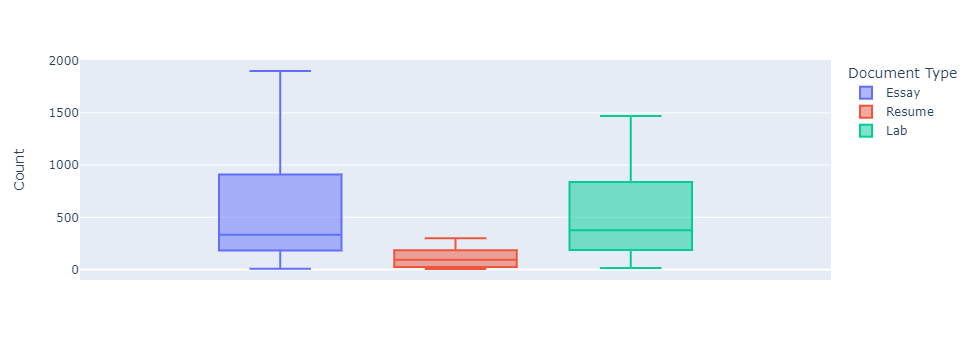

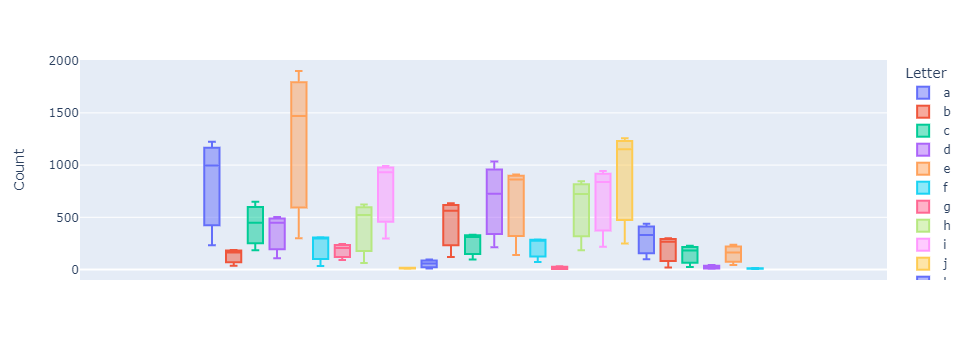

In [126]:
alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 
            'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r',
            's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

def ReshapeData(df):
    frequencies_by_document = merged_data.transpose().reset_index()

    frequencies_by_document.rename(columns = {'index' : 'Document Type'}, inplace = True)

    frequencies_by_document = frequencies_by_document.melt(id_vars = ["Document Type"], var_name = "Letter", value_name = "Count")

    frequencies_by_document = frequencies_by_document.loc[~frequencies_by_document['Count'].isin(alphabet)]




px.box(frequencies_by_document, y = 'Count', color = 'Document Type').show()

px.box(frequencies_by_document, y = 'Count', color = 'Letter').show()



In [ ]:
#px.box(merged_data.drop('Letter', axis = 1)).show()

#px.box(frequency_proportions.drop('Letter', axis = 1)).show()

#px.box(GroupByLetter).show()

                                                             Bar Graphs

In [ ]:
%matplotlib inline

def BarGraph(df, Title, Color, Y):
    bar_graph = go.Figure(data = [go.Bar(x = df["Letter"], y = df[Y])])
    bar_graph.update_traces(marker_color = Color)
    bar_graph.update_layout(title_text = Title)
    bar_graph.show()

BarGraph(EssayFrequency_df, "Frequencies of Letters in Essay", "darkviolet", 'Essay Frequency')

BarGraph(ResumeFrequency_df, "Frequencies of Letters in Resume", "deeppink", 'Resume Frequency')

BarGraph(LabFrequency_df, "Frequencies of Letters in Lab Report", "deepskyblue", 'Lab Frequency')


In [ ]:
%matplotlib inline

sns.set_palette("hls", 26)

def histogram(df, Title, X):
    hist = sns.displot(df, x = X, bins = 15, hue = 'Letter', multiple = 'stack', stat = 'probability')
    hist.fig.suptitle(Title)
    
histogram(EssayFrequency_df, "Frequencies of Letters in Essay", 'Essay Frequency')
histogram(ResumeFrequency_df, "Frequencies of Letters in Resume", 'Resume Frequency')
histogram(LabFrequency_df, "Frequencies of Letters in Lab Report", 'Lab Frequency')



In [ ]:

def CreateWordCloud(text):
    #Primary Source for writing this function: https://www.geeksforgeeks.org/generating-word-cloud-python/ 
    
    stopwords = set(STOPWORDS)

    # create wordcloud object
    wordcloud = WordCloud(background_color="white", max_words = 200, stopwords = stopwords)
    wordcloud.generate(text)

    plt.figure(figsize = (10, 10), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show()
    
CreateWordCloud(EssayText)
CreateWordCloud(ResumeText)
CreateWordCloud(LabText)
